In [1]:
import pandas as pd
import numpy as np
import yfinance  as yf
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm
import random
import joblib
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import matplotlib.pyplot as plt
from scipy.stats import norm, shapiro,  gaussian_kde
from scipy.integrate import quad
import pickle
from scipy import stats
import time
from tqdm import tqdm
import os


In [ ]:
# def download_data(data, period='5y'):
#     dfs = []
#     if isinstance(data, dict):
#         for name, ticker in data.items():
#             ticker_obj = yf.Ticker(ticker)
#             hist = ticker_obj.history(period=period)
#             hist.columns = [f"{name}_{col}" for col in hist.columns]  # Add prefix to the name
#             hist.index = pd.to_datetime(hist.index.map(lambda x: x.strftime('%Y-%m-%d')))
#             close_columns = [col for col in hist.columns if col.endswith('_Close')]
#             hist = hist[close_columns]
#             dfs.append(hist)
#     return dfs

# dicts = {#'commodities':commodities_dict,
#          #'b3_stocs': b3_stocks,
#          'SP500': sp500_dict,
#          #'NASDAC100':nasdaq_dict,
#          #'indexes': indexes_dict,
#          #'currencies': currencies_dict, 
#          #'crypto': crypto_dict}
#         }

# # storedAssets = []
# for key, ticker in tqdm(dicts.items()):
#     assets = download_data(ticker)  # Baixa os dados
#     for asset in assets:
#         storedAssets.append(asset)
# assets = storedAssets.copy()
# joblib.dump(assets, 'portfolios.pkl')

In [2]:
filepath = os.path.join('..', 'pkl', 'portfolios.pkl')




In [3]:
filepath
assets = joblib.load(filepath)

In [4]:

bound = 2 * 252  # Define o limite mínimo de tamanho para os ativos
assets = [asset[bound:] for asset in assets if len(asset) >= bound]


In [23]:
class Portfolio:
    """
    A class to manage investment portfolios.

    Attributes:
    - data (DataFrame): A DataFrame containing historical prices of assets.
    - invested_capital (float): The amount of capital invested in the portfolio.
    - window_size (int): The size of the window for processing data.
    - chunk_dfs (list): A list of DataFrames representing data chunks.
    - prices (np.array): An array containing the latest prices of assets.
    - names (list): A list of asset names.
    - dates (list): A list of last dates for each chunk.
    - sharpe_weights (np.array): Optimal weights for maximum Sharpe ratio.
    - min_risk_weights (np.array): Optimal weights for minimum risk.
    - max_sharpe_control (list): Portfolio optimized for maximum Sharpe ratio with rebalancing.
    - max_sharpe (list): Portfolio optimized for maximum Sharpe ratio without rebalancing.
    - min_risk_control (list): Portfolio optimized for minimum risk with rebalancing.
    - min_risk (list): Portfolio optimized for minimum risk without rebalancing.
    - even_weights (list): Portfolio with even weights.
    - smart_max_sharpe_control (list): Smartly rebalanced portfolio optimized for maximum Sharpe ratio.
    - smart_max_sharpe (list): Smartly rebalanced portfolio optimized for maximum Sharpe ratio without rebalancing.
    - smart_min_risk_control (list): Smartly rebalanced portfolio optimized for minimum risk.
    - smart_min_risk (list): Smartly rebalanced portfolio optimized for minimum risk without rebalancing.
    - smart_even_weights (list): Smartly rebalanced portfolio with even weights.
    - portfolio_ROI (list): Evaluation of portfolios' portfolio_portfolio_portfolio_ROI considering each round of optimization and the final ROI.
        
    """
    def __init__(self, data, invested_capital = 100000,  window_size=30):
        self.invested_capital = invested_capital
        self.data = data
        self.window_size = window_size
        
        self.chunk_dfs = self.process_data(window_size)
        self.prices = self.get_prices()
        self.names = self.get_asset_name()
        self.dates  = self.get_last_dates()
        self.sharpe_weights, self.max_sharpe_risk  = self.get_opt_values()
        self.min_risk_weights, self.min_risk = self.get_opt_values(objective = 'risk')
        self.max_sharpe_control= self.dummy_balancer(method='sharpe_control')
        self.max_sharpe = self.dummy_balancer(method = 'sharpe')
        self.min_risk_control = self.dummy_balancer(method = 'risk_control')
        self.min_risk = self.dummy_balancer(method = 'risk') 
        self.even_weights = self.dummy_balancer(method = 'even')
        self.smart_max_sharpe_control = self.smart_balancer(method='sharpe_control')
        self.smart_max_sharpe = self.smart_balancer(method = 'sharpe')
        self.smart_min_risk_control = self.smart_balancer(method = 'risk_control')
        self.smart_min_risk = self.smart_balancer(method = 'risk')
        self.smart_even_weights = self.smart_balancer(method = 'even')
        self.portfolio_ROI  = self.get_portfolio_ROI()
    
        self.plot_ROI = self.plot_ROI_over_time()
    
    
    def process_data(self, window_size):    
        """
        Processes data into chunks.portfolio_ROI

        Parameters:
        - window_size: Size of the window.

        Returns:
        - List of DataFrames representing data chunks.
        """
        chunk_dfs = []
        for i in range(0, len(self.data), window_size):
            if i + window_size <= len(self.data):
                chunk_df = self.data.iloc[i:i+window_size].copy()
            else:
                chunk_df = self.data.iloc[i:].copy()
        
            chunk_dfs.append(chunk_df)
            
        return chunk_dfs
    
    
    def simulate_frontier(self, chunk_df, risk_free_rate=0, trading_days=252, simulations=10000, objective='sharpe'):
        """
        Simulates optimal asset allocation based on the Sharpe ratio within a specified tolerance range,
        and selects the one with the highest Sharpe ratio.

        Parameters:
        - chunk_df: DataFrame containing asset prices.
        - risk_free_rate: Risk-free rate.
        - trading_days: Number of trading days.
        - simulations: Number of simulations.
        - sharpe_tolerance: Tolerance range for the Sharpe ratio.
        - objective: 'sharpe' or 'risk' to specify whether to maximize Sharpe ratio or minimize risk.

        Returns:
        - Numpy array representing optimal asset allocation with the highest Sharpe ratio or lowest positive standard deviation.
        """
        max_sharpe_ratio = -np.inf
        min_positive_sd = np.inf
        optimal_weights = None
        num_assets = len(chunk_df.columns)
        simple_returns = chunk_df.pct_change().dropna().mean() * trading_days
        cov_matrix = chunk_df.pct_change().dropna().cov() * trading_days

        for _ in range(simulations):
            weights = np.random.random(num_assets)
            weights /= np.sum(weights)
            returns = np.dot(weights, simple_returns)
            var = np.dot(weights.T, np.dot(cov_matrix, weights))
            sd = np.sqrt(var)

            if objective == 'sharpe':
                sharpe_ratio = (returns - risk_free_rate) / sd
                if sharpe_ratio > max_sharpe_ratio:
                    max_sharpe_ratio = sharpe_ratio
                    optimal_weights = weights
            elif objective == 'risk':
                if sd > 0 and sd < min_positive_sd:
                    min_positive_sd = sd
                    optimal_weights = weights
                    
            else:
                raise ValueError("Objective must be either 'sharpe' or 'risk'.")
        
        return optimal_weights, sd

    def get_opt_values(self, lower_bound=0.00, upper_bound=1, objective='sharpe'):
        
        """
        Calculate optimal portfolio weights for each chunk of data using mean-variance optimization.

        Parameters:
        lower_bound : float, optional
            The minimum bound for the weights. Default is 0.00.
        upper_bound : float, optional
            The maximum bound for the weights. Default is 1.
        objective : str, optional
            The objective for optimization. Can be 'sharpe' for maximizing the Sharpe ratio
            or 'min_volatility' for minimizing portfolio volatility. Default is 'sharpe'.
        Returns:
        np.array
            A numpy array of optimal weights for each chunk of data.
        """ 
        
        opt_weights = []
        pfl_risk = []
        
        for i, chunk_df in enumerate(self.chunk_dfs):
            try: 
                mu = expected_returns.mean_historical_return(chunk_df)
                S = risk_models.sample_cov(chunk_df)
                ef = EfficientFrontier(mu, S, weight_bounds=(lower_bound, upper_bound))
                if objective == 'sharpe':
                    ef.max_sharpe(risk_free_rate=0)
                else:
                    ef.min_volatility()
                cleaned_weights = ef.clean_weights()
                weights = [weight for _, weight in cleaned_weights.items()]
                

                risk = ef.port_volatility()
                opt_weights.append(weights)
                pfl_risk.append(risk)

            except Exception as e:
                
                #print(f"Error calculating optimal weights for chunk {i} \n Trying to simulate closest weights")
                if objective == 'sharpe':
                    simulated_max_sharpe_w, simulated_max_sharpe_risk  = self.simulate_frontier(chunk_df, risk_free_rate=0, objective=objective)
                    opt_weights.append(simulated_max_sharpe_w)
                    pfl_risk.append(simulated_max_sharpe_risk)
                else:
                    simulated_lowest_risk_w, simulated_lowest_risk = self.simulate_frontier(chunk_df, objective=objective)
                    opt_weights.append(simulated_lowest_risk_w)
                    pfl_risk.append(simulated_lowest_risk)
 
        optimal_weights = [weights for weights in opt_weights if weights is not None]
        optimal_risk = [risk for risk in pfl_risk if risk is not None]
        
        return  np.array(optimal_weights),  np.array(optimal_risk)

    def get_prices(self):
        prices = []
        for chunk_df in self.chunk_dfs:
            last_values = chunk_df.iloc[-1].values
            prices.append(last_values)
        return np.array(prices)

    def get_last_dates(self):
        """
        Gets the last index for each chunk.

        Returns:
        - List of last indices for each chunk.
        """
        last_indices = []
        for chunk_df in self.chunk_dfs[1:]:
            last_index = chunk_df.index[-1]
            last_index_date_only = str(last_index).split()[0]
            last_indices.append(last_index_date_only)
        return last_indices

    def get_asset_name(self, string ='_Close' ):
        """
        Gets the names of assets.

        Returns:
        - List of asset names.
        """
        names = []
        df = self.chunk_dfs[0]
        for column in df.columns:
            if  string in column:
                names.append(column.replace(string, ''))
            else:
                names.append(column)
        return names


    def smart_balancer(self, method='sharpe_control'):
        prices = self.prices
        if method == 'sharpe':
            weights = self.sharpe_weights
        elif method == 'risk':
            weights = self.min_risk_weights
        elif method == 'even':
            weights = np.full_like(prices, 1 / prices.shape[1])
        elif method == 'risk_control':
            weights = np.full_like(prices, self.min_risk_weights[0])
        else:
            weights = np.full_like(prices, self.sharpe_weights[0])
        
        sold_all = np.zeros_like(prices)
        funds = np.zeros_like(prices)
        total_capital = np.zeros_like(prices) 
        quantities = np.zeros_like(prices)
        smart_weights_balanced_portfolio = []
        for i in range(0, len(weights)):
            df = pd.DataFrame()
            if i == 0:
               quantities[0] = self.invested_capital * weights[i] / prices[i] 
               total_capital[0] = self.invested_capital * weights[i]
            else:
                for j in range(1, len(prices[i])):
                    if prices[i][j] > prices [i-1][j]:
                        funds[i][j] = prices[i][j]  * quantities[i-1][j]
                        sold_all[i][j] = 1
                    else:       
                        sold_all[i][j] = 0
                                
                quantities[i] =  np.sum(funds[i]) * weights[i] / prices[i]             
                  
                for k in range(len(quantities[i])):
                    if sold_all[i][k] == 0:
                        quantities[i][k] += quantities[i-1][k]
                        total_capital[i][k]  = quantities[i-1][k] * prices[i-1][k] + quantities[i][k] * prices[i][k]
                    else:
                        total_capital[i][k] = quantities[i][k] * prices[i][k]
                
                weights[i] = (total_capital[i] /np.sum(total_capital[i]))
                
                df[f'prices_t{i-1}'] = prices[i - 1]
                df[f'prices_t{i}'] = prices[i]
                df[f'weights_t{i-1}'] = weights[i-1]
                df[f'weights_t{i}'] = weights[i]
                df[f'funds_t{i}'] = funds[i]
                df[f'quantities_t{i-1}'] = quantities[i-1]
                df[f'quantities_bought_t{i}'] = quantities[i]
                df[f'quantities_t{i}'] = quantities[i]
                df[f'invested_capital_t{i-1}'] = quantities[i-1] * prices[i-1]
                df[f'invested_capital_t{i}'] = total_capital[i]
                df[f'cumulative_capital_t{i-1}'] = df[f'invested_capital_t{i-1}'].cumsum()
                df[f'cumulative_capital_t{i}'] = df[f'invested_capital_t{i}'].cumsum()
                df.index = self.names
                smart_weights_balanced_portfolio.append(df)

        return smart_weights_balanced_portfolio


    def dummy_balancer(self, method='sharpe_control'):
        """
        Adjusts the weights of a portfolio based on the specified method.
        
        Parameters:
        - self: Reference to the instance of the object containing the portfolio data, including prices (`prices`), Sharpe weights (`sharpe_weights`), minimum risk weights (`min_risk_weights`), and invested capital (`invested_capital`).
        - method (str, optional): The balancing method to use. Possible values are:
        - 'sharpe': Uses the Sharpe weights.
        - 'risk': Uses the minimum risk weights.
        - 'even': Distributes the weights equally among the assets.
        - 'risk_control': Uses a risk control strategy based on the first minimum risk weight.
        - Default is 'sharpe_control': Uses the first Sharpe weight.
        
        Returns:
        - simple_weights_balanced_portfolio (list of pandas.DataFrame): A list of DataFrames, each containing the prices, weights, quantities, and capital invested for each asset in each period.
        """
            
        prices = self.prices
        if method == 'sharpe':
            weights = self.sharpe_weights
        elif method == 'risk':
            weights = self.min_risk_weights
        elif method == 'even':
            weights = np.full_like(prices, 1 / prices.shape[1])
        elif method == 'risk_control':
            weights = np.full_like(prices, self.min_risk_weights[0])
        else:
            weights = np.full_like(prices, self.sharpe_weights[0])
            
        total_capital = np.zeros_like(prices) 
        quantities = np.zeros_like(prices)
        simple_weights_balanced_portfolio = []

        for i in range(1, len(weights)):
            df = pd.DataFrame()

            quantities[i-1] = self.invested_capital * weights[i-1] / prices[i-1] 
            total_capital[i] = quantities[i-1] * prices[i]   
            quantities[i] = np.sum(total_capital[i]) * weights[i] / prices[i]
 
            df[f'prices_t{i-1}'] = prices[i - 1]
            df[f'prices_t{i}'] = prices[i]
            df[f'weights_t{i-1}'] = weights[i-1]
            df[f'weights_t{i}'] = weights[i]
            df[f'funds_t{i}'] = prices[i] * quantities[i]
            df[f'quantities_t{i-1}'] = quantities[i-1]
            df[f'quantities_bought_t{i}'] = quantities[i] - quantities[i-1]
            df[f'quantities_t{i}'] = quantities[i]
            df[f'invested_capital_t{i-1}'] = quantities[i-1] * prices[i-1]
            df[f'invested_capital_t{i}'] = total_capital[i]
            df[f'cumulative_capital_t{i-1}'] = df[f'invested_capital_t{i-1}'].cumsum()
            df[f'cumulative_capital_t{i}'] = df[f'invested_capital_t{i}'].cumsum()
            df.index = self.names
            simple_weights_balanced_portfolio.append(df)
            
        return simple_weights_balanced_portfolio

    def get_portfolio_ROI(self):
        optimal_ROI = []
        portfolios = [
            ("sharpe_control", self.max_sharpe_control),
            ("sharpe", self.max_sharpe),
            ("min_risk_control", self.min_risk_control),
            ("min_risk", self.min_risk),
            ("even_weights", self.even_weights),
            ("smart_sharpe_control", self.smart_max_sharpe_control),
            ("smart_max_sharpe", self.smart_max_sharpe),
            ("smart_min_risk_control", self.smart_min_risk_control),
            ("smart_min_risk", self.smart_min_risk),
            ("smart_even_weights", self.smart_even_weights)
        ]
        num_periods = len(portfolios[0][1])
        
        for i in range(num_periods):
            opt_ROI = {} 
            for name, portfolio in portfolios:
                this_opt = portfolio[i][f'cumulative_capital_t{i+1}'].iloc[-1]
                previous_opt = portfolio[i][f'cumulative_capital_t{i}'].iloc[-1] if i > 0 else self.invested_capital
                previous_ROI = this_opt / previous_opt
                latest_ROI = this_opt / self.invested_capital
                opt_ROI[name] = {
                    "previous_ROI_df": round(previous_ROI, 4),
                    "lastest_ROI_df": round(latest_ROI, 4)
                }
            optimal_ROI.append(opt_ROI)

        #lastest_ROI_df = pd.DataFrame({k: [v[k]['lastest_ROI_df'] for v in optimal_ROI] for k in optimal_ROI[0].keys()})
        #previous_ROI_df = pd.DataFrame({k: [v[k]['previous_ROI_df'] for v in optimal_ROI] for k in optimal_ROI[0].keys()})
        
       # lastest_ROI_df = lastest_ROI_df[~lastest_ROI_df.index.duplicated(keep='first')]
       # previous_ROI_df = previous_ROI_df[~previous_ROI_df.index.duplicated(keep='first')]

        return optimal_ROI #lastest_ROI_df, #previous_ROI_df

    def plot_ROI_over_time(self, return_type='portfolio_ROI', method='smart'):
        # Seleciona o DataFrame com base no return_type
        if return_type == 'portfolio_ROI':
            df = self.portfolio_ROI
        elif return_type == 'optimization_ROI':
            df = self.optimization_ROI
        else:
            raise ValueError("Invalid return_type. Use 'portfolio_ROI' or 'optimization_ROI'.")

        # Filtra as colunas com base no método
        columns_to_plot = [col for col in df.columns if method in col]

        fig, ax = plt.subplots(figsize=(10, 6))
        for column in columns_to_plot:
            ax.plot(df.index, df[column], label=column)
        
        ax.set_xlabel('Date')
        ax.set_ylabel('ROI')
        ax.set_title('ROI Over Time for Different Strategies')
        ax.legend()
        ax.grid(True)
        ax.set_xticks(df.index)
        ax.set_xticklabels(self.dates, rotation=45)
        
        return fig

In [9]:
class BacktestPortfolios:
    def __init__(self, assets, num_combinations, num_assets, window_size=30, seed=52):
        self.assets = assets
        self.window_size = window_size
        self.num_assets = num_assets
        self.num_combinations = num_combinations
        self.seed = seed
        self.combinations = self.generate_combinations()
        self.portfolios = self.analyze_portfolios()
        self.smart_strategies, self.dummy_strategies = self.normalize_strategies()

    def generate_combinations(self):
        random.seed(self.seed)
        combinations = []
        for _ in range(self.num_combinations):
            shuffled_assets = self.assets[:]
            random.shuffle(shuffled_assets)
            combination = random.sample(shuffled_assets, self.num_assets)
            concatenated_df = pd.concat(combination, axis=1, join='inner')
            if not concatenated_df.empty:
                combinations.append(concatenated_df)
        return combinations

    def analyze_portfolios(self):
        portfolios = {}
        for i, df in tqdm(enumerate(self.combinations), total=self.num_combinations):
            portfolio_name = f'n_assets_{self.num_assets}_window_size_{self.window_size}_{i}'
            try:
                portfolios[portfolio_name] = Portfolio(data=df, invested_capital=100000, window_size=self.window_size)
            except Exception as e:
                print(f"Error analyzing portfolio {portfolio_name}: {e}")
        return portfolios

    def normalize_strategies(self, return_type='portfolio_ROI', roi_type='lastest_ROI_df', period='last'):
        smart_normalized_strategies = []
        dummy_normalized_strategies = []


        for _, plf in self.portfolios.items():
            roi_data = getattr(plf, return_type)

            if not roi_data: 
                continue

            if period == 'last':
                roi_data = [roi_data[-1]]

            for period_data in roi_data:
                smart_denominator = period_data.get('smart_even_weights', {}).get(roi_type, 1)
                dummy_denominator = period_data.get('even_weights', {}).get(roi_type, 1)

                smart_normalized = {key: value.get(roi_type, 0) / smart_denominator
                                    for key, value in period_data.items()
                                    if 'smart' in key and 'smart_even_weights' not in key
                                    }
                dummy_normalized = {key: value.get(roi_type, 0) / dummy_denominator
                                    for key, value in period_data.items()
                                    if 'smart' not in key and 'even_weights' not in key
                                    }

                smart_normalized_strategies.append(smart_normalized)
                dummy_normalized_strategies.append(dummy_normalized)

        return smart_normalized_strategies, dummy_normalized_strategies


In [18]:
class BacktestAnalysis:
    def __init__(self, smart_strategies, dummy_strategies):
        self.smart_strategies = smart_strategies
        self.dummy_strategies = dummy_strategies
        
    def test_distribution(self, keys='all'):
        distribution_results = []
        strategies = self.smart_strategies + self.dummy_strategies
        
        if keys == 'all':
            # Coleta todas as chaves existentes nos dicionários
            all_keys = set().union(*(s.keys() for s in strategies))
        else:
            all_keys = keys
            
        all_data = {key: [] for key in all_keys}
        
        for strategy in strategies:
            for key in all_data.keys():
                value = strategy.get(key, None)
                if value is not None:
                    if isinstance(value, (list, np.ndarray)):
                        all_data[key].extend(value)
                    else:
                        all_data[key].append(value)
                        
        for key in all_data.keys():
            if len(all_data[key]) >= 3:
                _, p_value = shapiro(all_data[key])
                normal = p_value > 0.05

                distribution_results.append({
                    'key': key,
                    'normal': normal,
                    'p_value': p_value
                })

                if normal:
                    self.plot_histogram(all_data[key], f'Strategy {key}')
                else:
                    self.plot_kde(all_data[key], f'Strategy {key}')
            else:
                print(f"Insufficient data for key '{key}' to perform normality test.")
        
        return distribution_results


    @staticmethod
    def plot_histogram(data, strategy, prob = 1):
        plt.figure(figsize=(12, 8))
        q1, q2, q3 = np.percentile(data, [25, 50, 75])
        n, bins, patches = plt.hist(data, bins=30, alpha=0.7, label=strategy, edgecolor='black')

        for patch, bin_left in zip(patches, bins[:-1]):
            if bin_left < q1:
                patch.set_facecolor('red')
            elif bin_left < q2:
                transition_ratio = (bin_left - q1) / (q2 - q1)
                patch.set_facecolor(plt.cm.Blues(transition_ratio))
            elif bin_left < q3:
                transition_ratio = (bin_left - q2) / (q3 - q2)
                patch.set_facecolor(plt.cm.Blues(transition_ratio))
            else:
                patch.set_facecolor('blue')

        mu, std = norm.fit(data)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        p = norm.pdf(bin_centers, mu, std)
        p_scaled = p * np.max(n) / np.max(p)
        plt.plot(bin_centers, p_scaled, 'k', linewidth=2, label='Normal Distribution', alpha=0.5)
        plt.axvline(x=1, color='r', linestyle='--', label='Value 1')
        probability = np.sum(np.array(data) > prob) / len(data)
        plt.legend([f'Probability of returns > 1: {probability:.2f}'])
        plt.title(f'Histogram of Initial Returns for: {strategy}  for {len(data)} combinations')
        plt.xlabel('Last_ROI')
        plt.ylabel('Frequency')
        plt.xlim(min(data) - 0.1 * abs(min(data)), max(data) + 0.1 * abs(max(data)))
        plt.ylim(0, max(n) + 0.25 * max(n))
        plt.grid(True)
        plt.show()

    @staticmethod
    def plot_kde(data, strategy, prob = 1):
        plt.figure(figsize=(12, 8))
        kde = gaussian_kde(data)
        x_values = np.linspace(min(data) - 0.1 * abs(min(data)), max(data) + 0.1 * abs(max(data)), 1000)
        y_values = kde(x_values)
        q1, q2, q3 = np.percentile(data, [25, 50, 75])

        plt.fill_between(x_values, y_values, where=(x_values < q1), color=plt.cm.Blues(0.2), alpha=0.5)
        plt.fill_between(x_values, y_values, where=(x_values >= q1) & (x_values < q2), color=plt.cm.Blues(0.4), alpha=0.5)
        plt.fill_between(x_values, y_values, where=(x_values >= q2) & (x_values < q3), color=plt.cm.Blues(0.6), alpha=0.5)
        plt.fill_between(x_values, y_values, where=(x_values >= q3), color=plt.cm.Blues(0.8), alpha=0.5)

        prob_greater_than = np.sum(np.array(data) > prob) / len(data)
        plt.axvline(x=1, color='r', linestyle='--', label=f'Probability > {prob}: {prob_greater_than:.2f} for {len(data)} combinations')
        plt.title(f'KDE Plot - {strategy}')
        plt.xlabel('ROI_initial_period')
        plt.ylabel('Density')
        plt.legend()
        plt.xlim(min(data) - 0.1 * abs(min(data)), max(data) + 0.1 * abs(max(data)))
        plt.ylim(0, np.max(y_values) + 0.25 * np.max(y_values))
        plt.grid(False)
        
        
        plt.show()


In [15]:
windows = [120]
nassets = 5
seeds = [37]

# 120 seed 37
ncombinations = 200

backtest_results = {}

for window in windows:
    for seed in tqdm(seeds):
        backtest_portfolio = BacktestPortfolios(assets=assets, num_combinations=ncombinations, num_assets=nassets, window_size=window, seed=seed)
        backtest_results[f'backtest_window_{window}_seed_{seed}'] = backtest_portfolio
        
        with open(f'backtest_{nassets}_assets_for_{ncombinations}_ptf_window_{window}_seed_{seed}.pkl', 'wb') as f:
            pickle.dump(backtest_portfolio, f)


  0%|          | 0/1 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [38]:
import pickle
import glob
import os

def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

directory_path = '..\\pkl'
pattern = os.path.join(directory_path, '*180*.pkl')
pickle_files = glob.glob(pattern)
print(pickle_files)

all_smart_strategies = []
all_dummy_strategies = []

for pickle_file in pickle_files:
    backtest_portfolio = load_pickle(pickle_file)
    all_smart_strategies.extend(backtest_portfolio.smart_strategies)
    all_dummy_strategies.extend(backtest_portfolio.dummy_strategies)


['..\\pkl\\backtest_5_assets_for_200_ptf_window_180_seed_10.pkl', '..\\pkl\\backtest_5_assets_for_200_ptf_window_180_seed_20.pkl', '..\\pkl\\backtest_5_assets_for_200_ptf_window_180_seed_30.pkl', '..\\pkl\\backtest_5_assets_for_200_ptf_window_180_seed_37.pkl', '..\\pkl\\backtest_5_assets_for_200_ptf_window_180_seed_42.pkl']


In [51]:
import os
import glob
import pickle
import pandas as pd

def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

def calculate_probability_of_returns(returns, threshold=1):
    return sum(r > threshold for r in returns) / len(returns)

directory_path = '..\\pkl'
window_sizes = [30, 60, 90, 120, 150, 180]
pattern = '*.pkl'

all_smart_strategies = {ws: [] for ws in window_sizes}
all_dummy_strategies = {ws: [] for ws in window_sizes}

for window_size in window_sizes:
    pickle_files = glob.glob(os.path.join(directory_path, f'*{window_size}*.pkl'))
    
    for pickle_file in pickle_files:
        backtest_portfolio = load_pickle(pickle_file)
        all_smart_strategies[window_size].extend(backtest_portfolio.smart_strategies)
        all_dummy_strategies[window_size].extend(backtest_portfolio.dummy_strategies)



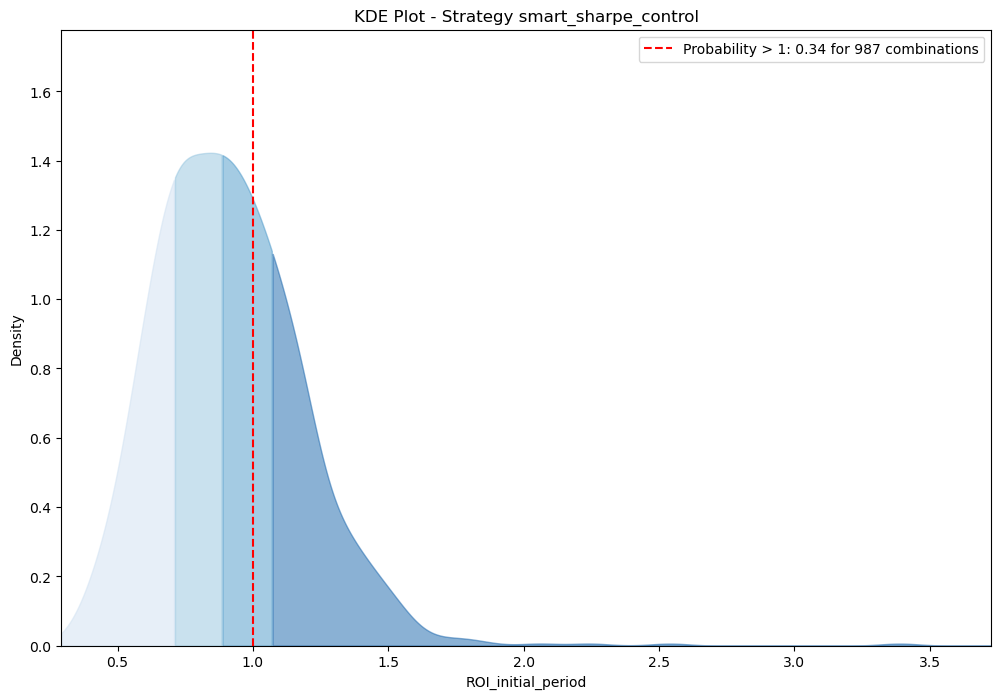

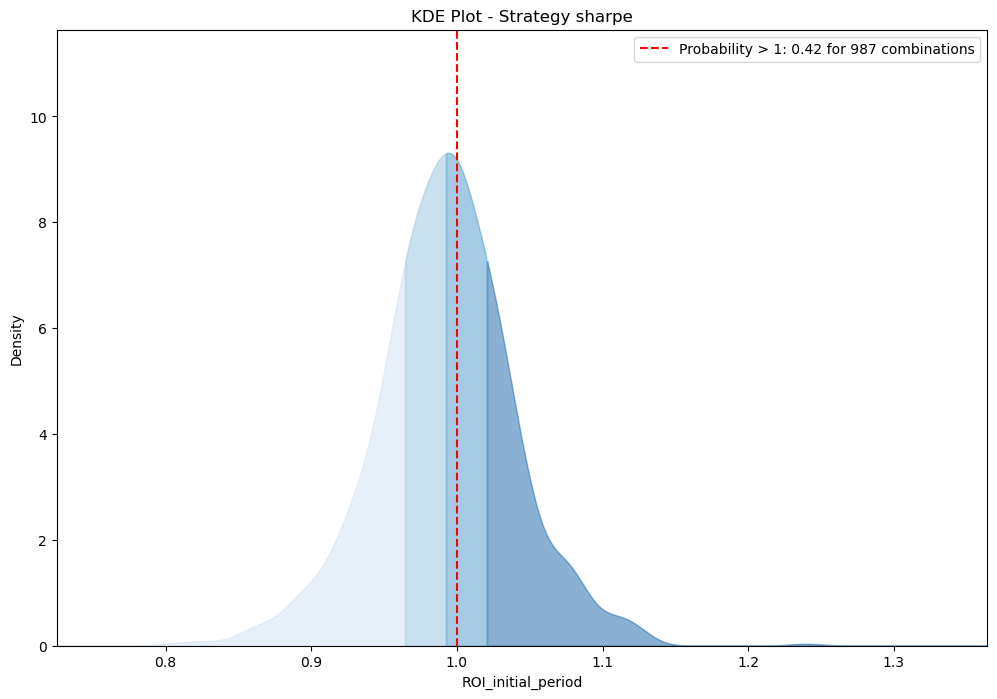

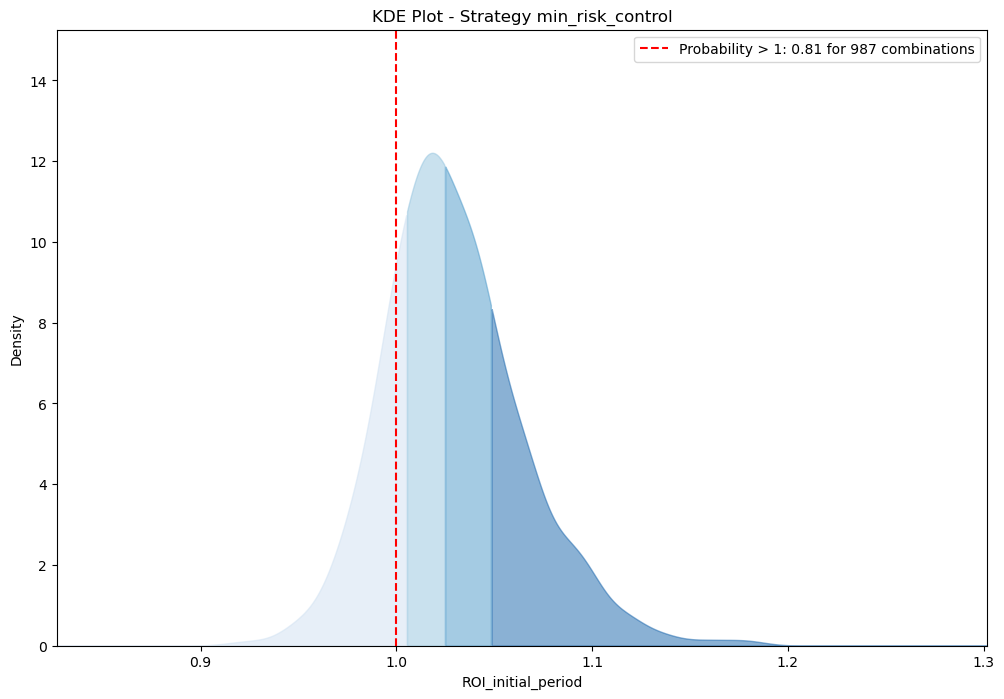

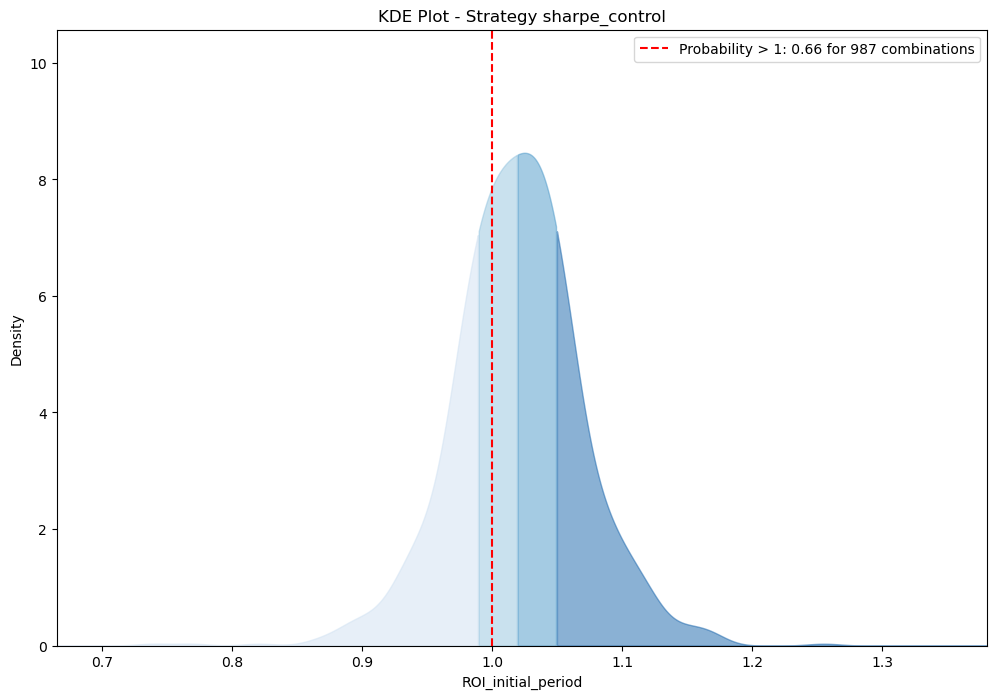

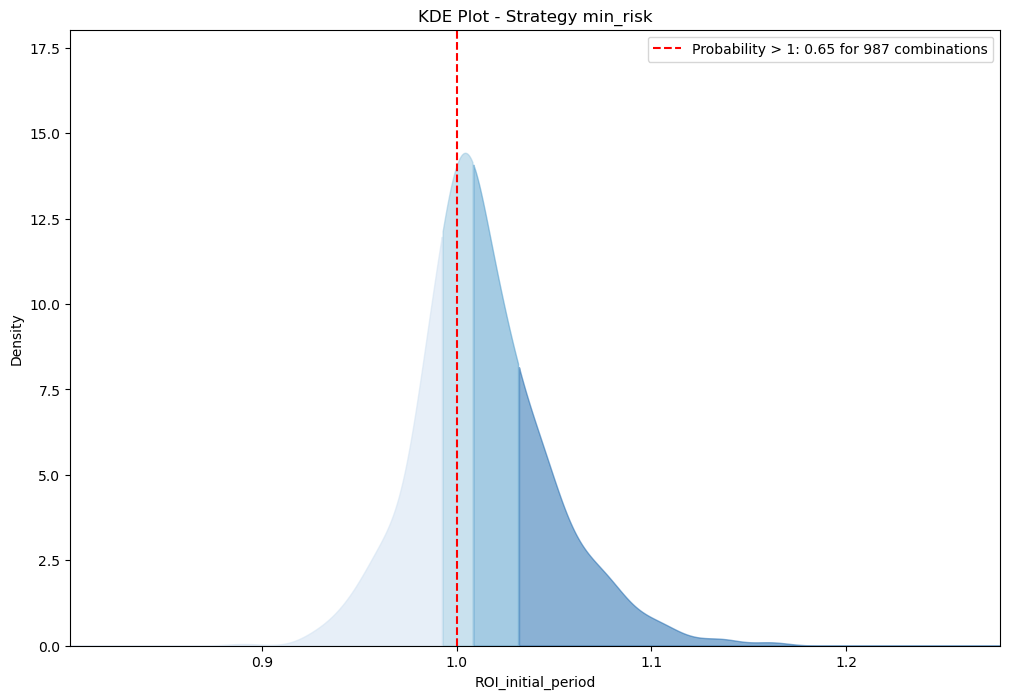

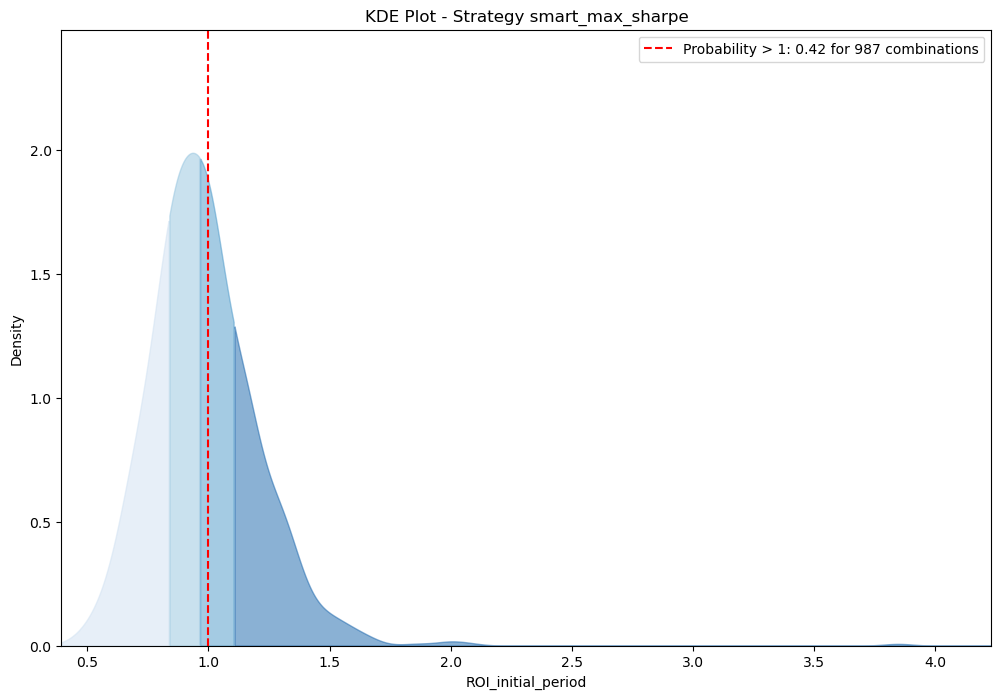

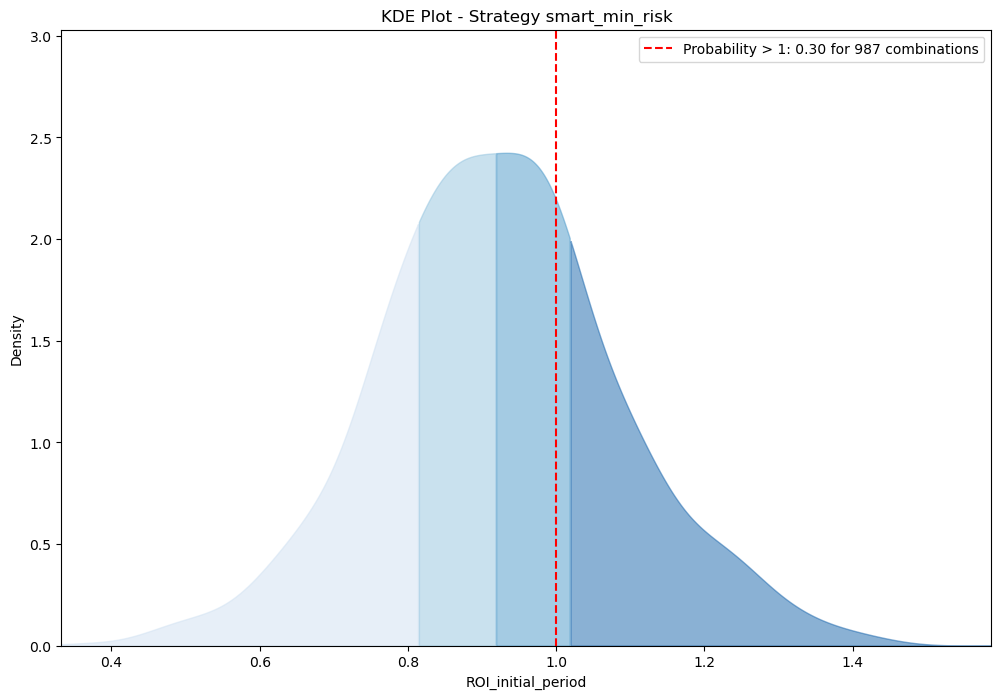

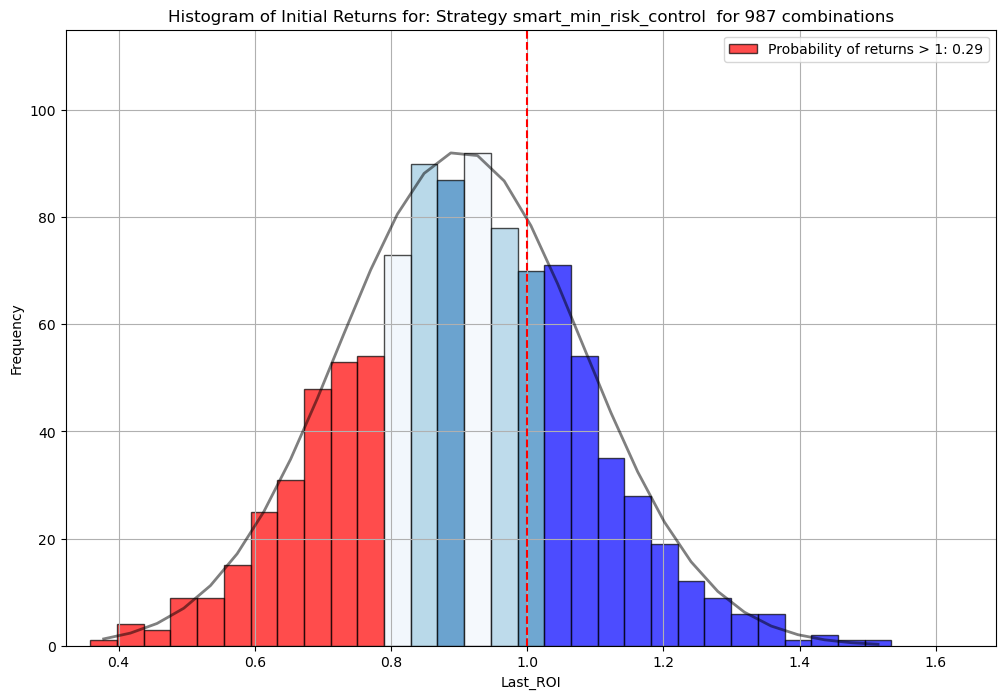

In [39]:
analysis = BacktestAnalysis(all_smart_strategies, all_dummy_strategies)
results = analysis.test_distribution()